In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set()
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import sklearn

In [368]:
#train = pd.read_csv('./data_1-First/Fina_Train.csv')
#test = pd.read_csv('./data_1-First/Fina_Test.csv')
train = pd.read_csv('Train-19-10-Final.csv')

test = pd.read_csv('Test-19-10-Final.csv')

In [369]:
y = train['TARGET(PRICE_IN_LACS)']
x = train.drop(['TARGET(PRICE_IN_LACS)','ADDRESS','CITY','READY_TO_MOVE','Lo+Li','SQFT_P_ROOM','Rare_House'],axis=1)


In [370]:
train.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)', 'CITY', 'IN_CITY', 'CITY_2',
       'SQFT_P_ROOM', 'Lo+Li', 'Rare_House', 'City_Type'],
      dtype='object')

In [371]:
cat_col=['BHK_NO.','IN_CITY', 'CITY_2','City_Type']

### Data Engineering

In [372]:
x['Area'] =pd.qcut(x['SQUARE_FT'],5,labels=[0,1,2,3,4])


In [373]:
x['Area'] = x['Area'].astype(int)

### Mapping

In [374]:
bhk_or_rak = {'BHK':1,
             'RK':0}
posted_by = {'Dealer':0,'Owner':1,'Builder':2}
city_typ = {'Metro':0,'Town':1,'Village':2,'City':3,'Unknown':4}


In [375]:
for df in [x,test]:
    df['BHK_OR_RK'] = df['BHK_OR_RK'].replace(bhk_or_rak)
    df['POSTED_BY'] = df['POSTED_BY'].replace(posted_by)
    df['City_Type'] = df['City_Type'].replace(city_typ)
    #df['l*l'] = np.log(df['LONGITUDE'])*df['LATITUDE']

In [376]:
city_encode = LabelEncoder()
city_encode.fit(list(set(x['CITY_2']) | set(test['CITY_2'])))
in_city_encode = LabelEncoder()
in_city_encode.fit(list(set(x['IN_CITY']) | set(test['IN_CITY'])))
for df in [x,test]:
    df['CITY_2'] = city_encode.transform(df['CITY_2'] )
    df['IN_CITY'] = in_city_encode.transform(df['IN_CITY'].astype(str))

In [377]:
#for df in [x,test]:
    #df['BHK_CITY'] = df['CITY_2']+df['BHK_NO.']
    #df['BHK_IN_CITY'] = df['IN_CITY']+df['BHK_NO.']
    #df['multi'] = df['BHK_NO.']*df['SQUARE_FT']

In [378]:
#final_x = x.drop(['LATITUDE','LONGITUDE'],axis=1)


In [379]:
#final_x = x.drop()
final_x = x.copy()
#final_x = x.drop([  'BHK_OR_RK','READY_TO_MOVE'],axis=1)


### Correlation

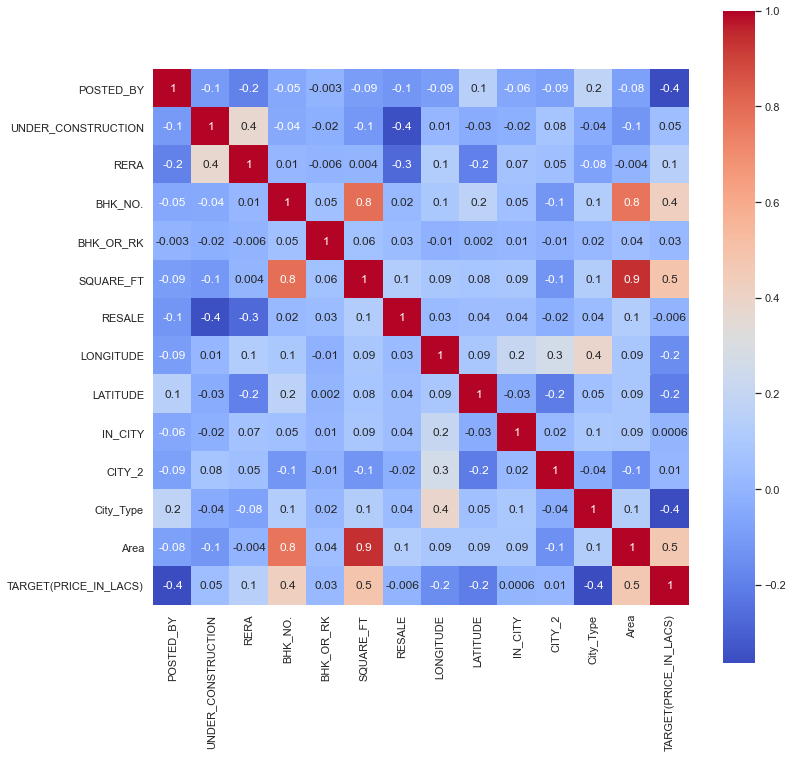

In [380]:
plt.figure(figsize=(12,12))
sns.heatmap(final_x.merge(y,on=x.index).drop(['key_0'],axis=1).corr(),annot=True,cmap='coolwarm',square=True,fmt='0.1g')

## Split

In [381]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [382]:
'''scaler = StandardScaler().fit(final_x)
temp = scaler.transform(final_x)
final_x = pd.DataFrame(data = temp,columns=final_x.columns.values)'''

'scaler = StandardScaler().fit(final_x)\ntemp = scaler.transform(final_x)\nfinal_x = pd.DataFrame(data = temp,columns=final_x.columns.values)'

In [383]:
x_train,x_test,y_train,y_test = train_test_split(final_x,y,train_size=0.7,random_state=22)

x_test,x_valid,y_test,y_valid = train_test_split(x_test,y_test,train_size=0.5,random_state=2)
x_train.shape,x_test.shape,x_valid.shape

((18251, 13), (3911, 13), (3912, 13))

### XGBoost

In [384]:
from xgboost import XGBRegressor,plot_importance,plot_tree
import xgboost as xgb

In [385]:
'''reg = XGBRegressor(n_estimators=2000,objective='reg:squaredlogerror',verbosity=1,tree_method='exact',n_jobs=-1)
score = reg.fit(final_x,y)
pred = score.predict(final_x)
train_acc = 100-mean_squared_log_error(np.exp(y),np.exp(pred))*100
#test_acc = 100-mean_squared_log_error(np.exp(y_test),np.exp(score.predict(x_test)))*100
print('Train',train_acc)
#print('Test',test_acc)
'''

"reg = XGBRegressor(n_estimators=2000,objective='reg:squaredlogerror',verbosity=1,tree_method='exact',n_jobs=-1)\nscore = reg.fit(final_x,y)\npred = score.predict(final_x)\ntrain_acc = 100-mean_squared_log_error(np.exp(y),np.exp(pred))*100\n#test_acc = 100-mean_squared_log_error(np.exp(y_test),np.exp(score.predict(x_test)))*100\nprint('Train',train_acc)\n#print('Test',test_acc)\n"

In [386]:
x_train.shape

(18251, 13)

In [387]:
max_depth = [ 6,7,8,9,]
eta = [0.2,0.3,0.4]
early_stopping_rounds = 20

In [388]:
y.max()

6.016157159698354

In [397]:
#reg = XGBRegressor(objective='reg:squaredlogerror' ,n_jobs=-1,n_estimators=500,verbosity=1,eta=0.4,gamma=0.001,max_depth= 6, min_child_weight= 1)
eval_set = [(x_train, y_train),(x_test, y_test),(x_valid,y_valid) ]
reg = XGBRegressor(objective='reg:squaredlogerror' ,n_jobs=4,n_estimators=3000,gamma=0.000001,eta=0.1,max_depth=9)

score = reg.fit(x_train,y_train,verbose=True,eval_metric=['rmsle'],eval_set=eval_set,early_stopping_rounds=40)
pred = score.predict(x_train)
train_acc = 100-mean_squared_log_error(np.exp(y_train),np.exp(pred))*100
test_acc = 100-mean_squared_log_error(np.exp(y_test),np.exp(score.predict(x_test)))*100
#train_acc = 100-mean_squared_log_error(y_train,pred)*100
#test_acc = 100-mean_squared_log_error(y_test,score.predict(x_test))*100

print('Train',train_acc)
print('Test',test_acc)


[0]	validation_0-rmsle:1.16855	validation_1-rmsle:1.16696	validation_2-rmsle:1.16934
Multiple eval metrics have been passed: 'validation_2-rmsle' will be used for early stopping.

Will train until validation_2-rmsle hasn't improved in 40 rounds.
[1]	validation_0-rmsle:1.11655	validation_1-rmsle:1.11496	validation_2-rmsle:1.11726
[2]	validation_0-rmsle:1.06565	validation_1-rmsle:1.06407	validation_2-rmsle:1.06629
[3]	validation_0-rmsle:1.01588	validation_1-rmsle:1.01431	validation_2-rmsle:1.01645
[4]	validation_0-rmsle:0.96728	validation_1-rmsle:0.96572	validation_2-rmsle:0.96777
[5]	validation_0-rmsle:0.91988	validation_1-rmsle:0.91834	validation_2-rmsle:0.92029
[6]	validation_0-rmsle:0.87372	validation_1-rmsle:0.87217	validation_2-rmsle:0.87405
[7]	validation_0-rmsle:0.82881	validation_1-rmsle:0.82726	validation_2-rmsle:0.82907
[8]	validation_0-rmsle:0.78520	validation_1-rmsle:0.78365	validation_2-rmsle:0.78538
[9]	validation_0-rmsle:0.74291	validation_1-rmsle:0.74136	validation_2-rms

[94]	validation_0-rmsle:0.05888	validation_1-rmsle:0.06266	validation_2-rmsle:0.06151
[95]	validation_0-rmsle:0.05870	validation_1-rmsle:0.06249	validation_2-rmsle:0.06135
[96]	validation_0-rmsle:0.05862	validation_1-rmsle:0.06243	validation_2-rmsle:0.06131
[97]	validation_0-rmsle:0.05859	validation_1-rmsle:0.06242	validation_2-rmsle:0.06128
[98]	validation_0-rmsle:0.05855	validation_1-rmsle:0.06239	validation_2-rmsle:0.06125
[99]	validation_0-rmsle:0.05839	validation_1-rmsle:0.06226	validation_2-rmsle:0.06116
[100]	validation_0-rmsle:0.05822	validation_1-rmsle:0.06214	validation_2-rmsle:0.06103
[101]	validation_0-rmsle:0.05819	validation_1-rmsle:0.06213	validation_2-rmsle:0.06102
[102]	validation_0-rmsle:0.05809	validation_1-rmsle:0.06205	validation_2-rmsle:0.06093
[103]	validation_0-rmsle:0.05805	validation_1-rmsle:0.06203	validation_2-rmsle:0.06091
[104]	validation_0-rmsle:0.05796	validation_1-rmsle:0.06196	validation_2-rmsle:0.06083
[105]	validation_0-rmsle:0.05792	validation_1-rms

[189]	validation_0-rmsle:0.05344	validation_1-rmsle:0.05897	validation_2-rmsle:0.05779
[190]	validation_0-rmsle:0.05334	validation_1-rmsle:0.05889	validation_2-rmsle:0.05771
[191]	validation_0-rmsle:0.05328	validation_1-rmsle:0.05887	validation_2-rmsle:0.05766
[192]	validation_0-rmsle:0.05321	validation_1-rmsle:0.05883	validation_2-rmsle:0.05761
[193]	validation_0-rmsle:0.05316	validation_1-rmsle:0.05881	validation_2-rmsle:0.05757
[194]	validation_0-rmsle:0.05315	validation_1-rmsle:0.05881	validation_2-rmsle:0.05757
[195]	validation_0-rmsle:0.05313	validation_1-rmsle:0.05878	validation_2-rmsle:0.05754
[196]	validation_0-rmsle:0.05307	validation_1-rmsle:0.05874	validation_2-rmsle:0.05751
[197]	validation_0-rmsle:0.05302	validation_1-rmsle:0.05872	validation_2-rmsle:0.05747
[198]	validation_0-rmsle:0.05294	validation_1-rmsle:0.05865	validation_2-rmsle:0.05741
[199]	validation_0-rmsle:0.05289	validation_1-rmsle:0.05864	validation_2-rmsle:0.05738
[200]	validation_0-rmsle:0.05278	validation

[284]	validation_0-rmsle:0.04958	validation_1-rmsle:0.05688	validation_2-rmsle:0.05567
[285]	validation_0-rmsle:0.04957	validation_1-rmsle:0.05689	validation_2-rmsle:0.05567
[286]	validation_0-rmsle:0.04956	validation_1-rmsle:0.05688	validation_2-rmsle:0.05566
[287]	validation_0-rmsle:0.04953	validation_1-rmsle:0.05686	validation_2-rmsle:0.05564
[288]	validation_0-rmsle:0.04949	validation_1-rmsle:0.05684	validation_2-rmsle:0.05563
[289]	validation_0-rmsle:0.04945	validation_1-rmsle:0.05683	validation_2-rmsle:0.05561
[290]	validation_0-rmsle:0.04942	validation_1-rmsle:0.05682	validation_2-rmsle:0.05560
[291]	validation_0-rmsle:0.04940	validation_1-rmsle:0.05680	validation_2-rmsle:0.05559
[292]	validation_0-rmsle:0.04935	validation_1-rmsle:0.05679	validation_2-rmsle:0.05557
[293]	validation_0-rmsle:0.04930	validation_1-rmsle:0.05675	validation_2-rmsle:0.05555
[294]	validation_0-rmsle:0.04928	validation_1-rmsle:0.05675	validation_2-rmsle:0.05555
[295]	validation_0-rmsle:0.04923	validation

[379]	validation_0-rmsle:0.04738	validation_1-rmsle:0.05592	validation_2-rmsle:0.05464
[380]	validation_0-rmsle:0.04737	validation_1-rmsle:0.05592	validation_2-rmsle:0.05463
[381]	validation_0-rmsle:0.04736	validation_1-rmsle:0.05591	validation_2-rmsle:0.05463
[382]	validation_0-rmsle:0.04733	validation_1-rmsle:0.05589	validation_2-rmsle:0.05461
[383]	validation_0-rmsle:0.04732	validation_1-rmsle:0.05589	validation_2-rmsle:0.05460
[384]	validation_0-rmsle:0.04729	validation_1-rmsle:0.05588	validation_2-rmsle:0.05459
[385]	validation_0-rmsle:0.04726	validation_1-rmsle:0.05585	validation_2-rmsle:0.05457
[386]	validation_0-rmsle:0.04723	validation_1-rmsle:0.05583	validation_2-rmsle:0.05456
[387]	validation_0-rmsle:0.04720	validation_1-rmsle:0.05581	validation_2-rmsle:0.05454
[388]	validation_0-rmsle:0.04718	validation_1-rmsle:0.05581	validation_2-rmsle:0.05455
[389]	validation_0-rmsle:0.04715	validation_1-rmsle:0.05580	validation_2-rmsle:0.05453
[390]	validation_0-rmsle:0.04711	validation

[474]	validation_0-rmsle:0.04578	validation_1-rmsle:0.05528	validation_2-rmsle:0.05392
[475]	validation_0-rmsle:0.04575	validation_1-rmsle:0.05526	validation_2-rmsle:0.05391
[476]	validation_0-rmsle:0.04573	validation_1-rmsle:0.05526	validation_2-rmsle:0.05390
[477]	validation_0-rmsle:0.04571	validation_1-rmsle:0.05525	validation_2-rmsle:0.05389
[478]	validation_0-rmsle:0.04568	validation_1-rmsle:0.05523	validation_2-rmsle:0.05388
[479]	validation_0-rmsle:0.04566	validation_1-rmsle:0.05522	validation_2-rmsle:0.05388
[480]	validation_0-rmsle:0.04563	validation_1-rmsle:0.05523	validation_2-rmsle:0.05387
[481]	validation_0-rmsle:0.04560	validation_1-rmsle:0.05521	validation_2-rmsle:0.05387
[482]	validation_0-rmsle:0.04557	validation_1-rmsle:0.05520	validation_2-rmsle:0.05385
[483]	validation_0-rmsle:0.04554	validation_1-rmsle:0.05520	validation_2-rmsle:0.05385
[484]	validation_0-rmsle:0.04552	validation_1-rmsle:0.05519	validation_2-rmsle:0.05384
[485]	validation_0-rmsle:0.04550	validation

KeyboardInterrupt: 

In [392]:
np.sqrt(mean_squared_log_error(y_valid,score.predict(x_valid)))

0.051599747522758525

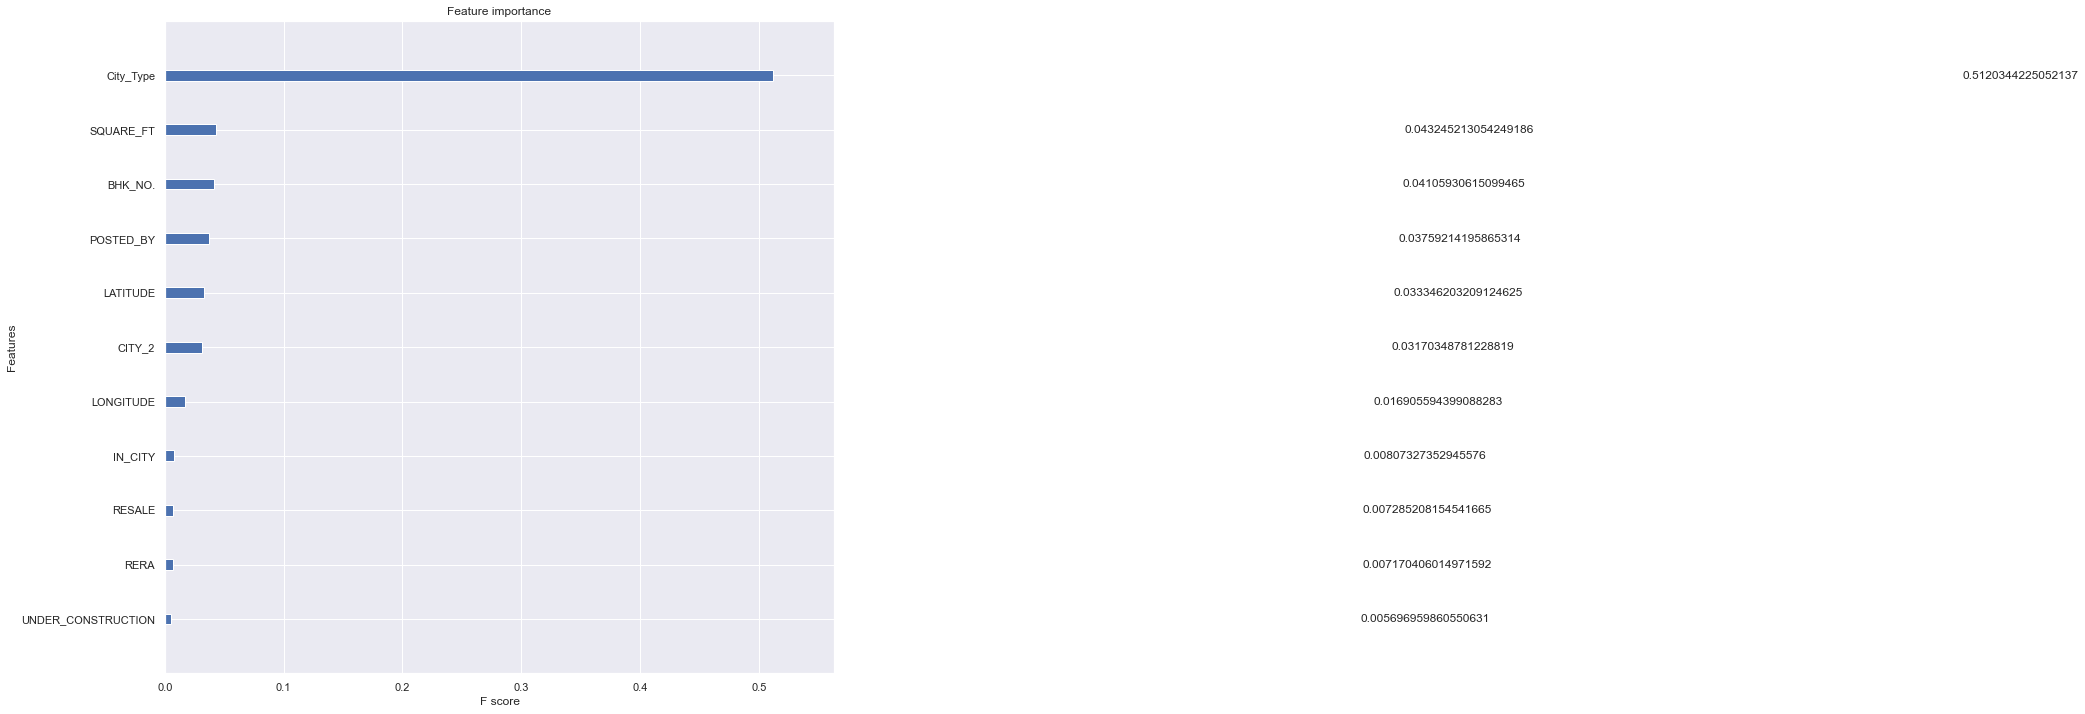

In [399]:
#fig,ax = plt.subplots(figsize=(12,8))
plot_importance(score,importance_type='gain')

### Grid Search

In [411]:
params = {
    'min_child_weight':[0.1,0.001,0.0001,1,3,4,5],
    'eta':[0.1,0.2,0.3],
    'gamma':[i/10.0 for i in range(1,6)],
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)],
    'max_depth': [6,7,8,9],
    'objective': ['reg:squaredlogerror'],
    'eval_metric':['rmsle'],
    'n_estimators': [2000],
    'n_jobs':[-1]
    
}
params_2 = {
    'max_depth': [9],
    'eta':[0.1],
    'gamma':[0.00001],
    'min_child_weight':[0.1,0.001,0.0001,1,3,4,5],
    'objective': ['reg:squaredlogerror'],
    'eval_metric':['rmsle'],
    'n_estimators': [2000],
    'n_jobs':[-1]
    
}

In [412]:
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params_2,scoring='neg_mean_squared_log_error',verbose=3,n_jobs=4,cv=3)
model  = grid.fit(x_train,y_train,verbose=True,eval_metric=['rmsle'],eval_set=eval_set,early_stopping_rounds=40)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[0]	validation_0-rmsle:1.16855	validation_1-rmsle:1.16696	validation_2-rmsle:1.16934
Multiple eval metrics have been passed: 'validation_2-rmsle' will be used for early stopping.

Will train until validation_2-rmsle hasn't improved in 40 rounds.
[1]	validation_0-rmsle:1.11655	validation_1-rmsle:1.11496	validation_2-rmsle:1.11726
[2]	validation_0-rmsle:1.06565	validation_1-rmsle:1.06407	validation_2-rmsle:1.06629
[3]	validation_0-rmsle:1.01588	validation_1-rmsle:1.01431	validation_2-rmsle:1.01645
[4]	validation_0-rmsle:0.96728	validation_1-rmsle:0.96572	validation_2-rmsle:0.96777
[5]	validation_0-rmsle:0.91988	validation_1-rmsle:0.91834	validation_2-rmsle:0.92029


[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:  4.5min finished


[6]	validation_0-rmsle:0.87372	validation_1-rmsle:0.87217	validation_2-rmsle:0.87405
[7]	validation_0-rmsle:0.82881	validation_1-rmsle:0.82726	validation_2-rmsle:0.82907
[8]	validation_0-rmsle:0.78520	validation_1-rmsle:0.78365	validation_2-rmsle:0.78538
[9]	validation_0-rmsle:0.74291	validation_1-rmsle:0.74136	validation_2-rmsle:0.74302
[10]	validation_0-rmsle:0.70197	validation_1-rmsle:0.70042	validation_2-rmsle:0.70203
[11]	validation_0-rmsle:0.66239	validation_1-rmsle:0.66086	validation_2-rmsle:0.66242
[12]	validation_0-rmsle:0.62422	validation_1-rmsle:0.62270	validation_2-rmsle:0.62419
[13]	validation_0-rmsle:0.58746	validation_1-rmsle:0.58600	validation_2-rmsle:0.58741
[14]	validation_0-rmsle:0.55213	validation_1-rmsle:0.55072	validation_2-rmsle:0.55203
[15]	validation_0-rmsle:0.51824	validation_1-rmsle:0.51690	validation_2-rmsle:0.51808
[16]	validation_0-rmsle:0.48582	validation_1-rmsle:0.48453	validation_2-rmsle:0.48559
[17]	validation_0-rmsle:0.45486	validation_1-rmsle:0.45363

[102]	validation_0-rmsle:0.04939	validation_1-rmsle:0.05817	validation_2-rmsle:0.05673
[103]	validation_0-rmsle:0.04933	validation_1-rmsle:0.05812	validation_2-rmsle:0.05670
[104]	validation_0-rmsle:0.04925	validation_1-rmsle:0.05808	validation_2-rmsle:0.05664
[105]	validation_0-rmsle:0.04908	validation_1-rmsle:0.05799	validation_2-rmsle:0.05652
[106]	validation_0-rmsle:0.04900	validation_1-rmsle:0.05795	validation_2-rmsle:0.05650
[107]	validation_0-rmsle:0.04884	validation_1-rmsle:0.05785	validation_2-rmsle:0.05639
[108]	validation_0-rmsle:0.04871	validation_1-rmsle:0.05778	validation_2-rmsle:0.05631
[109]	validation_0-rmsle:0.04864	validation_1-rmsle:0.05776	validation_2-rmsle:0.05628
[110]	validation_0-rmsle:0.04859	validation_1-rmsle:0.05772	validation_2-rmsle:0.05625
[111]	validation_0-rmsle:0.04846	validation_1-rmsle:0.05769	validation_2-rmsle:0.05620
[112]	validation_0-rmsle:0.04828	validation_1-rmsle:0.05760	validation_2-rmsle:0.05611
[113]	validation_0-rmsle:0.04814	validation

[197]	validation_0-rmsle:0.04279	validation_1-rmsle:0.05540	validation_2-rmsle:0.05401
[198]	validation_0-rmsle:0.04276	validation_1-rmsle:0.05540	validation_2-rmsle:0.05400
[199]	validation_0-rmsle:0.04270	validation_1-rmsle:0.05536	validation_2-rmsle:0.05398
[200]	validation_0-rmsle:0.04265	validation_1-rmsle:0.05534	validation_2-rmsle:0.05396
[201]	validation_0-rmsle:0.04257	validation_1-rmsle:0.05531	validation_2-rmsle:0.05392
[202]	validation_0-rmsle:0.04254	validation_1-rmsle:0.05530	validation_2-rmsle:0.05392
[203]	validation_0-rmsle:0.04249	validation_1-rmsle:0.05527	validation_2-rmsle:0.05390
[204]	validation_0-rmsle:0.04246	validation_1-rmsle:0.05526	validation_2-rmsle:0.05390
[205]	validation_0-rmsle:0.04244	validation_1-rmsle:0.05525	validation_2-rmsle:0.05390
[206]	validation_0-rmsle:0.04243	validation_1-rmsle:0.05525	validation_2-rmsle:0.05390
[207]	validation_0-rmsle:0.04242	validation_1-rmsle:0.05525	validation_2-rmsle:0.05389
[208]	validation_0-rmsle:0.04236	validation

[292]	validation_0-rmsle:0.03908	validation_1-rmsle:0.05443	validation_2-rmsle:0.05322
[293]	validation_0-rmsle:0.03906	validation_1-rmsle:0.05443	validation_2-rmsle:0.05322
[294]	validation_0-rmsle:0.03903	validation_1-rmsle:0.05443	validation_2-rmsle:0.05322
[295]	validation_0-rmsle:0.03902	validation_1-rmsle:0.05443	validation_2-rmsle:0.05322
[296]	validation_0-rmsle:0.03898	validation_1-rmsle:0.05443	validation_2-rmsle:0.05321
[297]	validation_0-rmsle:0.03896	validation_1-rmsle:0.05443	validation_2-rmsle:0.05321
[298]	validation_0-rmsle:0.03895	validation_1-rmsle:0.05443	validation_2-rmsle:0.05320
[299]	validation_0-rmsle:0.03893	validation_1-rmsle:0.05443	validation_2-rmsle:0.05320
[300]	validation_0-rmsle:0.03889	validation_1-rmsle:0.05444	validation_2-rmsle:0.05321
[301]	validation_0-rmsle:0.03887	validation_1-rmsle:0.05444	validation_2-rmsle:0.05321
[302]	validation_0-rmsle:0.03884	validation_1-rmsle:0.05443	validation_2-rmsle:0.05320
[303]	validation_0-rmsle:0.03881	validation

[387]	validation_0-rmsle:0.03654	validation_1-rmsle:0.05396	validation_2-rmsle:0.05275
[388]	validation_0-rmsle:0.03652	validation_1-rmsle:0.05396	validation_2-rmsle:0.05275
[389]	validation_0-rmsle:0.03649	validation_1-rmsle:0.05396	validation_2-rmsle:0.05275
[390]	validation_0-rmsle:0.03647	validation_1-rmsle:0.05396	validation_2-rmsle:0.05275
[391]	validation_0-rmsle:0.03646	validation_1-rmsle:0.05396	validation_2-rmsle:0.05274
[392]	validation_0-rmsle:0.03644	validation_1-rmsle:0.05396	validation_2-rmsle:0.05274
[393]	validation_0-rmsle:0.03643	validation_1-rmsle:0.05395	validation_2-rmsle:0.05274
[394]	validation_0-rmsle:0.03643	validation_1-rmsle:0.05395	validation_2-rmsle:0.05274
[395]	validation_0-rmsle:0.03641	validation_1-rmsle:0.05394	validation_2-rmsle:0.05273
[396]	validation_0-rmsle:0.03637	validation_1-rmsle:0.05394	validation_2-rmsle:0.05273
[397]	validation_0-rmsle:0.03635	validation_1-rmsle:0.05394	validation_2-rmsle:0.05273
[398]	validation_0-rmsle:0.03635	validation

[482]	validation_0-rmsle:0.03474	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[483]	validation_0-rmsle:0.03471	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[484]	validation_0-rmsle:0.03470	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[485]	validation_0-rmsle:0.03470	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[486]	validation_0-rmsle:0.03469	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[487]	validation_0-rmsle:0.03467	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[488]	validation_0-rmsle:0.03466	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[489]	validation_0-rmsle:0.03464	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[490]	validation_0-rmsle:0.03463	validation_1-rmsle:0.05368	validation_2-rmsle:0.05237
[491]	validation_0-rmsle:0.03461	validation_1-rmsle:0.05368	validation_2-rmsle:0.05236
[492]	validation_0-rmsle:0.03460	validation_1-rmsle:0.05367	validation_2-rmsle:0.05236
[493]	validation_0-rmsle:0.03458	validation

[577]	validation_0-rmsle:0.03308	validation_1-rmsle:0.05349	validation_2-rmsle:0.05213
[578]	validation_0-rmsle:0.03306	validation_1-rmsle:0.05348	validation_2-rmsle:0.05212
[579]	validation_0-rmsle:0.03302	validation_1-rmsle:0.05348	validation_2-rmsle:0.05211
[580]	validation_0-rmsle:0.03301	validation_1-rmsle:0.05348	validation_2-rmsle:0.05212
[581]	validation_0-rmsle:0.03297	validation_1-rmsle:0.05347	validation_2-rmsle:0.05211
[582]	validation_0-rmsle:0.03295	validation_1-rmsle:0.05347	validation_2-rmsle:0.05210
[583]	validation_0-rmsle:0.03290	validation_1-rmsle:0.05347	validation_2-rmsle:0.05212
[584]	validation_0-rmsle:0.03286	validation_1-rmsle:0.05345	validation_2-rmsle:0.05211
[585]	validation_0-rmsle:0.03286	validation_1-rmsle:0.05345	validation_2-rmsle:0.05211
[586]	validation_0-rmsle:0.03285	validation_1-rmsle:0.05345	validation_2-rmsle:0.05211
[587]	validation_0-rmsle:0.03283	validation_1-rmsle:0.05344	validation_2-rmsle:0.05210
[588]	validation_0-rmsle:0.03280	validation

[672]	validation_0-rmsle:0.03108	validation_1-rmsle:0.05324	validation_2-rmsle:0.05193
[673]	validation_0-rmsle:0.03105	validation_1-rmsle:0.05323	validation_2-rmsle:0.05192
[674]	validation_0-rmsle:0.03103	validation_1-rmsle:0.05323	validation_2-rmsle:0.05192
[675]	validation_0-rmsle:0.03100	validation_1-rmsle:0.05323	validation_2-rmsle:0.05192
[676]	validation_0-rmsle:0.03099	validation_1-rmsle:0.05323	validation_2-rmsle:0.05193
[677]	validation_0-rmsle:0.03098	validation_1-rmsle:0.05323	validation_2-rmsle:0.05193
[678]	validation_0-rmsle:0.03097	validation_1-rmsle:0.05323	validation_2-rmsle:0.05193
[679]	validation_0-rmsle:0.03096	validation_1-rmsle:0.05323	validation_2-rmsle:0.05192
[680]	validation_0-rmsle:0.03095	validation_1-rmsle:0.05323	validation_2-rmsle:0.05192
[681]	validation_0-rmsle:0.03095	validation_1-rmsle:0.05322	validation_2-rmsle:0.05192
[682]	validation_0-rmsle:0.03094	validation_1-rmsle:0.05323	validation_2-rmsle:0.05192
[683]	validation_0-rmsle:0.03093	validation

[767]	validation_0-rmsle:0.02969	validation_1-rmsle:0.05316	validation_2-rmsle:0.05174
[768]	validation_0-rmsle:0.02967	validation_1-rmsle:0.05317	validation_2-rmsle:0.05174
[769]	validation_0-rmsle:0.02966	validation_1-rmsle:0.05317	validation_2-rmsle:0.05174
[770]	validation_0-rmsle:0.02964	validation_1-rmsle:0.05316	validation_2-rmsle:0.05173
[771]	validation_0-rmsle:0.02963	validation_1-rmsle:0.05316	validation_2-rmsle:0.05174
[772]	validation_0-rmsle:0.02959	validation_1-rmsle:0.05317	validation_2-rmsle:0.05174
[773]	validation_0-rmsle:0.02958	validation_1-rmsle:0.05317	validation_2-rmsle:0.05174
[774]	validation_0-rmsle:0.02957	validation_1-rmsle:0.05317	validation_2-rmsle:0.05174
[775]	validation_0-rmsle:0.02955	validation_1-rmsle:0.05318	validation_2-rmsle:0.05174
[776]	validation_0-rmsle:0.02955	validation_1-rmsle:0.05317	validation_2-rmsle:0.05173
[777]	validation_0-rmsle:0.02954	validation_1-rmsle:0.05317	validation_2-rmsle:0.05173
[778]	validation_0-rmsle:0.02953	validation

[862]	validation_0-rmsle:0.02834	validation_1-rmsle:0.05313	validation_2-rmsle:0.05165
[863]	validation_0-rmsle:0.02831	validation_1-rmsle:0.05312	validation_2-rmsle:0.05165
[864]	validation_0-rmsle:0.02830	validation_1-rmsle:0.05312	validation_2-rmsle:0.05165
[865]	validation_0-rmsle:0.02829	validation_1-rmsle:0.05312	validation_2-rmsle:0.05165
[866]	validation_0-rmsle:0.02828	validation_1-rmsle:0.05312	validation_2-rmsle:0.05165
[867]	validation_0-rmsle:0.02826	validation_1-rmsle:0.05312	validation_2-rmsle:0.05165
[868]	validation_0-rmsle:0.02825	validation_1-rmsle:0.05312	validation_2-rmsle:0.05165
[869]	validation_0-rmsle:0.02824	validation_1-rmsle:0.05312	validation_2-rmsle:0.05164
[870]	validation_0-rmsle:0.02824	validation_1-rmsle:0.05312	validation_2-rmsle:0.05164
[871]	validation_0-rmsle:0.02823	validation_1-rmsle:0.05312	validation_2-rmsle:0.05164
[872]	validation_0-rmsle:0.02822	validation_1-rmsle:0.05312	validation_2-rmsle:0.05164
[873]	validation_0-rmsle:0.02822	validation

[957]	validation_0-rmsle:0.02699	validation_1-rmsle:0.05307	validation_2-rmsle:0.05152
[958]	validation_0-rmsle:0.02697	validation_1-rmsle:0.05307	validation_2-rmsle:0.05152
[959]	validation_0-rmsle:0.02696	validation_1-rmsle:0.05307	validation_2-rmsle:0.05152
[960]	validation_0-rmsle:0.02693	validation_1-rmsle:0.05307	validation_2-rmsle:0.05151
[961]	validation_0-rmsle:0.02692	validation_1-rmsle:0.05307	validation_2-rmsle:0.05151
[962]	validation_0-rmsle:0.02692	validation_1-rmsle:0.05306	validation_2-rmsle:0.05152
[963]	validation_0-rmsle:0.02689	validation_1-rmsle:0.05306	validation_2-rmsle:0.05152
[964]	validation_0-rmsle:0.02688	validation_1-rmsle:0.05306	validation_2-rmsle:0.05152
[965]	validation_0-rmsle:0.02685	validation_1-rmsle:0.05306	validation_2-rmsle:0.05153
[966]	validation_0-rmsle:0.02683	validation_1-rmsle:0.05306	validation_2-rmsle:0.05152
[967]	validation_0-rmsle:0.02680	validation_1-rmsle:0.05306	validation_2-rmsle:0.05152
[968]	validation_0-rmsle:0.02679	validation

[1051]	validation_0-rmsle:0.02564	validation_1-rmsle:0.05300	validation_2-rmsle:0.05147
[1052]	validation_0-rmsle:0.02562	validation_1-rmsle:0.05300	validation_2-rmsle:0.05147
[1053]	validation_0-rmsle:0.02561	validation_1-rmsle:0.05300	validation_2-rmsle:0.05147
[1054]	validation_0-rmsle:0.02561	validation_1-rmsle:0.05301	validation_2-rmsle:0.05147
[1055]	validation_0-rmsle:0.02560	validation_1-rmsle:0.05301	validation_2-rmsle:0.05147
[1056]	validation_0-rmsle:0.02559	validation_1-rmsle:0.05301	validation_2-rmsle:0.05147
[1057]	validation_0-rmsle:0.02558	validation_1-rmsle:0.05301	validation_2-rmsle:0.05147
[1058]	validation_0-rmsle:0.02556	validation_1-rmsle:0.05301	validation_2-rmsle:0.05147
[1059]	validation_0-rmsle:0.02555	validation_1-rmsle:0.05301	validation_2-rmsle:0.05147
[1060]	validation_0-rmsle:0.02554	validation_1-rmsle:0.05301	validation_2-rmsle:0.05147
[1061]	validation_0-rmsle:0.02554	validation_1-rmsle:0.05301	validation_2-rmsle:0.05147
[1062]	validation_0-rmsle:0.0255

[1145]	validation_0-rmsle:0.02473	validation_1-rmsle:0.05297	validation_2-rmsle:0.05143
[1146]	validation_0-rmsle:0.02473	validation_1-rmsle:0.05297	validation_2-rmsle:0.05143
[1147]	validation_0-rmsle:0.02473	validation_1-rmsle:0.05297	validation_2-rmsle:0.05143
[1148]	validation_0-rmsle:0.02473	validation_1-rmsle:0.05297	validation_2-rmsle:0.05143
[1149]	validation_0-rmsle:0.02472	validation_1-rmsle:0.05297	validation_2-rmsle:0.05143
[1150]	validation_0-rmsle:0.02470	validation_1-rmsle:0.05298	validation_2-rmsle:0.05143
[1151]	validation_0-rmsle:0.02470	validation_1-rmsle:0.05298	validation_2-rmsle:0.05143
[1152]	validation_0-rmsle:0.02469	validation_1-rmsle:0.05298	validation_2-rmsle:0.05143
[1153]	validation_0-rmsle:0.02469	validation_1-rmsle:0.05298	validation_2-rmsle:0.05143
[1154]	validation_0-rmsle:0.02468	validation_1-rmsle:0.05298	validation_2-rmsle:0.05143
[1155]	validation_0-rmsle:0.02467	validation_1-rmsle:0.05298	validation_2-rmsle:0.05143
[1156]	validation_0-rmsle:0.0246

[1239]	validation_0-rmsle:0.02366	validation_1-rmsle:0.05296	validation_2-rmsle:0.05137
[1240]	validation_0-rmsle:0.02365	validation_1-rmsle:0.05296	validation_2-rmsle:0.05136
[1241]	validation_0-rmsle:0.02363	validation_1-rmsle:0.05296	validation_2-rmsle:0.05136
[1242]	validation_0-rmsle:0.02362	validation_1-rmsle:0.05296	validation_2-rmsle:0.05136
[1243]	validation_0-rmsle:0.02361	validation_1-rmsle:0.05296	validation_2-rmsle:0.05137
[1244]	validation_0-rmsle:0.02360	validation_1-rmsle:0.05296	validation_2-rmsle:0.05137
[1245]	validation_0-rmsle:0.02359	validation_1-rmsle:0.05296	validation_2-rmsle:0.05137
[1246]	validation_0-rmsle:0.02357	validation_1-rmsle:0.05296	validation_2-rmsle:0.05137
[1247]	validation_0-rmsle:0.02355	validation_1-rmsle:0.05296	validation_2-rmsle:0.05138
[1248]	validation_0-rmsle:0.02354	validation_1-rmsle:0.05296	validation_2-rmsle:0.05138
[1249]	validation_0-rmsle:0.02352	validation_1-rmsle:0.05296	validation_2-rmsle:0.05138
[1250]	validation_0-rmsle:0.0235

In [415]:
model.best_estimator_,model.best_score_

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1,
              eval_metric='rmsle', gamma=1e-05, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=9,
              min_child_weight=0.001, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='reg:squaredlogerror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None),
 -0.0028992485874408847)

In [416]:
np.sqrt(mean_squared_log_error(y_valid,model.predict(x_valid)))

0.051359810653596696

### Randomised Search

In [414]:
from scipy import stats
from scipy.stats import randint

In [44]:
x_valid.to_csv('Valid_x.csv')
y_valid.to_csv('Valid_y.csv')

In [ ]:
param_dist = {'n_estimators': [3000],
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'gamma':stats.uniform(0, 1),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': stats.uniform(0, 1)
             }
model = RandomizedSearchCV(xgb, param_distributions = param_dist,scoring='neg_mean_squared_log_error',verbose=3,n_jobs=4,cv=3)
model  = grid.fit(x_train,y_train,verbose=True,eval_metric=['rmsle'],eval_set=eval_set,early_stopping_rounds=40)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [409]:
plot_importance(,importance_type='gain')

TypeError: 'XGBRegressor' object is not callable

In [ ]:
validation_0-rmsle:0.04115	validation_1-rmsle:0.05546	validation_2-rmsle:0.05218


validation_0-rmsle:0.02974	validation_1-rmsle:0.05053	validation_2-rmsle:0.04940

reg = XGBRegressor(objective='reg:squaredlogerror' ,n_jobs=-1,n_estimators=1000,eta=0.3,max_depth=9,gamma=0.00001)

score = reg.fit(x_train,y_train,verbose=True,eval_metric=['rmsle'],eval_set=eval_set,early_stopping_rounds=20)


results = reg.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Valid')

ax.legend()
plt.ylabel('rmsle ')
plt.title('XGBoost rmsle ')
plt.show()

In [ ]:
#fig,ax = plt.subplots(figsize=(12,12))


## Cross Validation

In [46]:
from sklearn.model_selection import KFold,cross_validate

In [47]:
scv = KFold(n_splits=5,shuffle=True,random_state=37)

In [48]:
score = cross_validate(reg,final_x,y,scoring='neg_mean_squared_log_error',cv=scv,n_jobs=3,verbose=2)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  2.1min remaining:  1.4min


KeyboardInterrupt: 

In [ ]:
-1*score['test_score']

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(np.exp(y_train),np.exp(pred),alpha=0.2)

## Prediction

In [33]:
#test = pd.read_csv('./Test-19-10.csv')
test = test.drop(['ADDRESS','CITY','READY_TO_MOVE', 'SQFT_P_ROOM', 'Lo+Li','BHK_OR_RK'],axis=1)

In [34]:
test.head()

,Unnamed: 0,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,RESALE,LONGITUDE,LATITUDE,IN_CITY,CITY_2,Rare_House,City_Type
0,0,1,0,0,1,545.171340,1,21.262000,4.291113,3857,278,0,1
1,1,0,1,1,2,800.000000,0,18.966114,4.292489,6411,172,0,0
2,2,0,0,0,2,1257.096513,1,22.592200,4.482832,6002,164,0,0
3,3,0,0,0,3,1400.329489,1,26.988300,4.325253,3797,124,0,3
4,4,1,0,0,1,430.477830,1,22.700000,4.288677,4881,195,0,2


In [43]:
test = test.iloc[:,1:]

In [44]:
test.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,RESALE,LONGITUDE,LATITUDE,IN_CITY,CITY_2,Rare_House,City_Type
0,1,0,0,1,545.171340,1,21.262000,4.291113,3857,278,0,1
1,0,1,1,2,800.000000,0,18.966114,4.292489,6411,172,0,0
2,0,0,0,2,1257.096513,1,22.592200,4.482832,6002,164,0,0
3,0,0,0,3,1400.329489,1,26.988300,4.325253,3797,124,0,3
4,1,0,0,1,430.477830,1,22.700000,4.288677,4881,195,0,2


In [45]:
test['LONGITUDE'] = np.log(test['LONGITUDE'])
final_test = test.copy()

G:\Installed\envs\tensorflowenv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
final_test.shape

(68720, 12)

In [49]:
final_test.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,RESALE,LONGITUDE,LATITUDE,IN_CITY,CITY_2,Rare_House,City_Type
0,1,0,0,1,545.171340,1,3.056921,4.291113,3857,278,0,1
1,0,1,1,2,800.000000,0,2.942654,4.292489,6411,172,0,0
2,0,0,0,2,1257.096513,1,3.117605,4.482832,6002,164,0,0
3,0,0,0,3,1400.329489,1,3.295403,4.325253,3797,124,0,3
4,1,0,0,1,430.477830,1,3.122365,4.288677,4881,195,0,2


In [50]:
final_test['TARGET(PRICE_IN_LACS)'] = np.exp(model.predict(final_test))

In [51]:
final_test['TARGET(PRICE_IN_LACS)'].head()

0         12.980648
1         75.837021
2         59.076042
3         29.405912
4         16.870773
5         17.644035
6         55.313114
7         33.243065
8         41.387436
9        219.865463
10       176.964920
11        84.869629
12       107.081139
13        51.534103
14        47.996956
15       104.416069
16        58.101917
17        11.008905
18        57.437634
19        74.063553
20        62.166546
21        53.940155
22        60.814785
23        67.650871
24        33.205170
25        26.508713
26        24.931128
27        21.515846
28        41.040096
29        39.435894
30        43.929543
31        44.921944
32        45.909119
33        74.812881
34        79.246887
35        38.259323
36        29.522032
37       199.137283
38       245.647400
39        26.443228
40        57.473934
41        31.576738
42        29.572464
43       112.678040
44        98.954422
45       178.171982
46        13.675179
47       250.215530
48        16.540377
49        17.731836


In [52]:
final_test['TARGET(PRICE_IN_LACS)'].to_csv('Submission 17.csv',index=False)